Script to automatically extract training data based on the first derivative from a single input file. The idea is the same as for template matching, but in some cases a derivative based approach may make more sense (e.g. when there are different event populations that would require iterative runs of template matching with different templates).

We mostly used the template matching to extract training data and have not extensively tested the derivative based approach. However, we wanted to provide an alternative method to extract training data, which is why we included this simple implementation.

In [81]:
import sys
sys.path.append('../../core/')

from miniML import MiniTrace
import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy
from scipy.signal import find_peaks
from scipy import signal

import matplotlib
%matplotlib inline

Most settings that potentially need to be changed to run this script are listed here. The only other thing that needs to be adjusted are the tresholds used to identify peaks in the first derivative. They are based on the standard deviation of a filtered first derivative, so we can only define them after we get the gradients. See below.

In [82]:
# set the window size and the event direction
win_size = 600

# Set left and right number of points (relative to steepest rise) to be extracted.
left_buffer = int(1/6*win_size)
right_buffer = win_size - left_buffer


# Size of the Hann Window used for filtering the data
filter_win = 50
event_direction = 'negative' # -1 if negative, 1 otherwise, see below. Kept as string to keep consistency with usual miniML naming.

if event_direction == 'negative':
    event_direction = -1
else:
    event_direction = 1

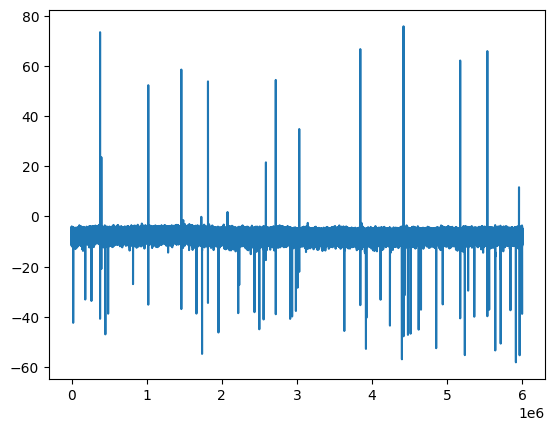

In [83]:
path = './example_recordings/'
myfile = 'B_2020-06-09_002.h5'
save_id = 'B_2020-06-09_002' # Used to save the training data.

filename = path+myfile
scaling = 1e12
unit = 'pA'

# get from h5 file
trace = MiniTrace.from_h5_file(filename=filename,
                               tracename='mini_data',
                               scaling=scaling,
                               unit=unit)

plt.plot(trace.data)
plt.show()

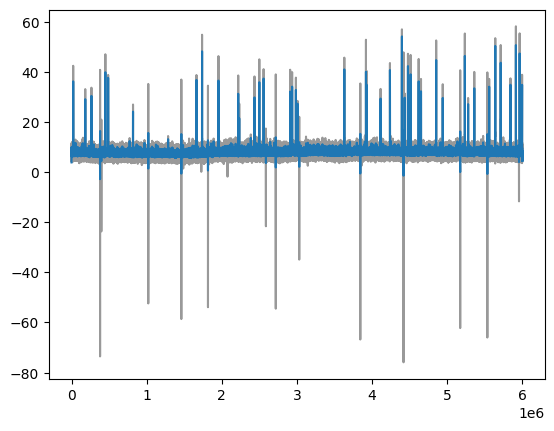

In [84]:
# For derivative based detetcion, filterting the data is required. Here we use a Hann window.
filter_data = True

if filter_data:
    win = signal.windows.hann(filter_win)
    data_trace = signal.convolve(trace.data, win, mode='same') / sum(win)
else:
    data_trace = trace.data

data_trace *= event_direction

plt.plot(trace.data*event_direction, c='k', alpha=0.4)
plt.plot(data_trace)
plt.show()

Once a suitable filter setting has been identified, we can find the first derivative or gradient, filter it and set our thresholds. Threshold will change for different preparations and noise levels and need to be adjusted when using this script with different data.

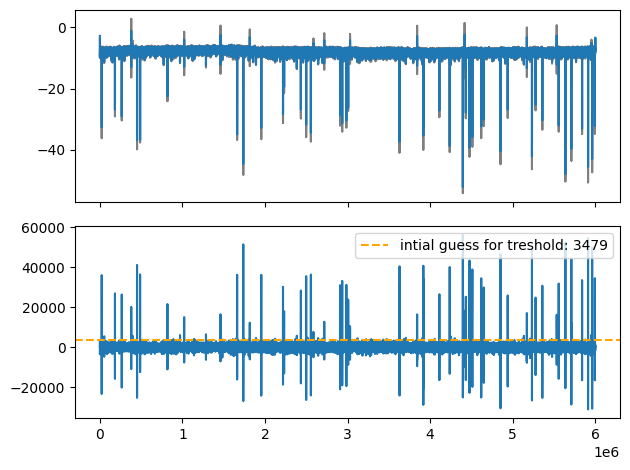

In [85]:
%matplotlib inline
# change inline to qt to zoom into the trace and check if the filter settings are in order and determine good thresholds.

# filter raw data trace, calculate gradient and filter first derivative trace
trace_convolved = signal.convolve(data_trace, win, mode='same') / sum(win)
gradient = np.gradient(trace_convolved, trace.sampling)
smth_gradient = signal.convolve(gradient, win, mode='same') / sum(win)

# set start and end of gradient to the mean of the entire data; helps to prevent picking up filter artifacts
smth_gradient[:win_size] = np.mean(smth_gradient)
smth_gradient[int(smth_gradient.shape[0]-(win_size*2)):] = np.mean(smth_gradient)

# Set the different thresholds.
threshold_intial_guess = int(4 * np.std(smth_gradient))

fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].plot(data_trace*event_direction, alpha=0.5, c='k')
axs[0].plot(trace_convolved*event_direction)

axs[1].plot(smth_gradient)

axs[1].axhline(threshold_intial_guess, c='orange', ls='--', label=f'intial guess for treshold: {threshold_intial_guess}')
axs[1].legend(loc='upper right')
plt.tight_layout()
plt.show()


Next, we need to define thresholds. Here we use 10*, 3* and 2* the standard devation of the data as thresholds. This needs to be adjusted for different data, e.g. by manually checking for good thresholds in the plot above.

In [86]:
# Set the different thresholds.
threshold_high = int(10 * np.std(smth_gradient))
threshold_mid = int(3 * np.std(smth_gradient))
threshold_low = int(2 * np.std(smth_gradient))

In [87]:
%matplotlib inline
cell_label, idx, events, scores = [], [], [], []



# Extract clear events
peaks, peak_params = find_peaks(x=smth_gradient, height=threshold_high, 
                    prominence=threshold_high)
print(len(peaks))

event_counter = 0
for ind, location in enumerate(peaks):
    if location < trace.data.shape[0] - int(win_size*1.5) and location > int(1/2*win_size):
        event = copy.deepcopy(trace.data[location-left_buffer:location+right_buffer])
        event -= np.mean(event[:int(win_size/10)])
        
        cell_label.append(filename)
        idx.append(location)
        events.append(event)
        scores.append(1)
        event_counter += 1

print(f'{event_counter} events extracted\n')

54
54 events extracted



In [88]:
# generate list with all indices of +/- (win_size/30) points of the previously found events to prevent duplicates
idx_range = []
buffer = int(win_size/30)
for my_ind in idx:
    idx_range += list(range(my_ind-buffer, my_ind+buffer))

# Use a relatively low threshold to extract FPs and small events.
peaks, peak_params = find_peaks(x=smth_gradient, height=threshold_mid, 
                    prominence=threshold_mid)
print(f'found {len(peaks)} events with mid threshold')
unclear_counter = 0
for ind, location in enumerate(peaks):
    if location < trace.data.shape[0] - int(win_size*1.5) and location > int(1/2*win_size):
        if location not in idx_range:
            event = copy.deepcopy(trace.data[location-left_buffer:location+right_buffer])
            event -= np.mean(event[:int(win_size/10)])
            
            cell_label.append(filename)
            idx.append(location)
            events.append(event)
            scores.append(2)
            unclear_counter += 1

print(f'{unclear_counter} unclear events extracted\n')

found 405 events with mid threshold
351 unclear events extracted



In [89]:
# Use a very low threshold. Remaining parts of the trace should be event free.
peaks, peak_params = find_peaks(x=smth_gradient, height=threshold_low, 
                    prominence=threshold_low)
print(f'found {len(peaks)} events with low threshold')

event_free_indices = []
for i in range(peaks.shape[0]-1):
    start = peaks[i] + win_size
    end = peaks[i+1] - win_size
    if end - start > 0:
        event_free_indices.append(np.arange(start, end))

event_free_indices = np.concatenate(event_free_indices)

unique_stretches = []
for ind, i in enumerate(event_free_indices):
    if ind==0:
        unique_stretches.append(i)
        next_possible = i+win_size
    
    if i < next_possible:
        pass
    else:
        unique_stretches.append(i)
        next_possible = i+win_size

print(f'found {len(unique_stretches)} unique data stretches containing no events')

# # Extract unique stretches to prevent overlap and redundancy in the data
if len(unique_stretches) <= event_counter:
    inds = np.array(unique_stretches)
else:
    inds = np.random.choice(np.array(unique_stretches), event_counter, replace=False)

# Extract events
noise_counter = 0
for location in sorted(inds):
        event = copy.deepcopy(trace.data[location:location+win_size])
        event -= np.mean(event[:int(win_size/10)])
        cell_label.append(filename)
        idx.append(location)
        events.append(event)
        scores.append(0)
        noise_counter += 1

print(f'{noise_counter} noise stretches extracted')

found 2345 events with low threshold
found 7077 unique data stretches containing no events
54 noise stretches extracted


In [90]:
# Save the result
x = np.array(events)
y = np.array(scores)
indices = np.array(idx)
print(x.shape)
save_dataset = f'./output/grad_{save_id}_example_training_data.h5'

if save_dataset:
    with h5py.File(save_dataset, 'w') as f:
        f.create_dataset("events", data=x)
        f.create_dataset("scores", data=y)
        f.create_dataset("raw_indices", data=indices)
        f.create_dataset("cell_label", data=np.array(cell_label, dtype='S'))

(459, 600)
